### Air Quality Anomaly detection  

Data from Kaggle's Air Quality Monitoring in European Cities data set ([available here](https://www.kaggle.com/datasets/yekenot/air-quality-monitoring-in-european-cities/data)).

In this notebook we will Try to identify days on which the pollution levels in Ancona Italy were particularly high. To do so we will compare a 7-day moving average to the mean and standard deviation of the full data set. This will give us an idea of when the pollution levels are particularly high.

In [39]:
# import useful packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# Define a class that will be used to detect outliers
class OutlierDetection:
    '''This class will be used to detect outliers in the data. It will calculate the z-score of the data and return the outliers.
     
    Attributes:
        data: Pandas DataFrame
            The input data for analysis.
        column: str
            The column in the data to analyze.
        sta_window: int
            The window size for calculating the short term average.
        lta_window: int
            The window size for calculating the long term average.
        
    Methods:
        get_moving_average: Calculate the moving average of the data.
        get_moving_std: Calculate the moving standard deviation of the data.
        detect_outliers: Detect the outliers in the data.

        '''
    def __init__(self, data, column, sta_window, lta_window):
        """
        Parameters:
        data: Pandas DataFrame
            The input data for analysis.
        column: str
            The column in the data to analyze.
        sta_window: int
            The window size for calculating the short term average.
        lta_window: int
            The window size for calculating the long term average. If this is set to 0 the average of the whole data set will be used.
        """
        self.data = data
        self.column = column
        self.sta_window = sta_window
        self.lta_window = lta_window

        # Clean the data
        self.clean_data()
        
        # Get the short term average
        self.get_moving_average(sta_window)
        # Get the long term average
        self.get_moving_average(lta_window)

        # Get the short term standard deviation
        self.get_moving_std(sta_window)
        # Get the long term standard deviation
        self.get_moving_std(lta_window)
    
    def clean_data(self):
        ''' Clean the data by removing missing values and converting the date column to datatime.'''
        # Convert the date column to datetime format
        self.data['Date'] = pd.to_datetime(self.data['Date'])
        self.data.dropna(inplace=True)

    def get_moving_average(self, window):
        ''' Calculate the moving average of the data.
        Parameters:
        window: int
            The window size for calculating the moving average.'''
        if window == 0:
            self.data['{}_{}d'.format(self.column, window)] = self.data[self.column].mean()
        else:
            self.data['{}_{}d'.format(self.column, window)] = self.data[self.column].rolling(window=window).mean()

    def get_moving_std(self, window):
        ''' Calculate the moving standard deviation of the data.
        Parameters:
        window: int
            The window size for calculating the moving standard deviation.'''
        if window == 0:
            self.data['{}_{}d_std'.format(self.column, window)] = self.data[self.column].std()
        else:
            self.data['{}_{}d_std'.format(self.column, window)] = self.data[self.column].rolling(window=window).std()

    def detect_outliers(self):
        ''' Detect the outliers in the data.'''
        # Calculate the z-score
        self.data['{}_z_score'.format(self.column)] = (self.data['{}_{}d'.format(self.column, self.sta_window)] - 
                                self.data['{}_{}d'.format(self.column, self.lta_window)]) / self.data['{}_{}d_std'.format(self.column, self.lta_window)]
        # Get the outliers
        self.data['{}_outlier'.format(self.column)] = (self.data['{}_z_score'.format(self.column)] > 3)
        return self.data

# Load the data
ancona = pd.read_csv('../archive/ancona_data.csv')
    
# Create an instance of the OutlierDetection class
outlier_detection = OutlierDetection(ancona, 'PM10', 7, 0)

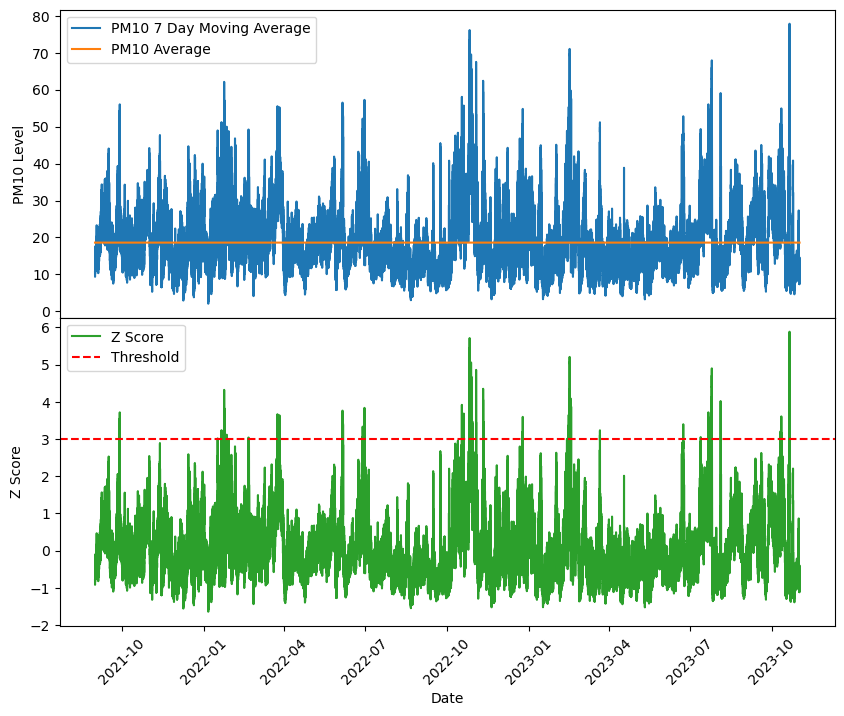

In [45]:
dataset = outlier_detection.detect_outliers()

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Top figure
ax1.plot(dataset['Date'], dataset['PM10_7d'], label='PM10 7 Day Moving Average')
ax1.plot(dataset['Date'], dataset['PM10_0d'], label='PM10 Average')
ax1.legend()
ax1.set_ylabel('PM10 Level')
# remove x-axis ticks
ax1.set_xticks([])

# Bottom figure
ax2.plot(dataset['Date'], dataset['PM10_z_score'], label='Z Score', color = 'C2')
ax2.axhline(3, color='r', linestyle='--', label='Threshold')
ax2.legend()
ax2.set_xlabel('Date')
ax2.set_ylabel('Z Score')
ax2.tick_params(axis='x', rotation=45)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()

This plot shows us that there are a few instances when the pollution levels got particularly high. The examples that jump out are around November of 2022 and February 2023 but there are a couple other time periods where we see this as well.

In [35]:
dataset.columns

Index(['Date', 'NO2', 'O3', 'PM10', 'PM2.5', 'Latitude', 'Longitude',
       'station_name', 'Wind-Speed (U)', 'Wind-Speed (V)', 'Dewpoint Temp',
       'Soil Temp', 'Total Percipitation', 'Vegitation (High)',
       'Vegitation (Low)', 'Temp', 'Relative Humidity', 'code', 'id',
       'PM10_7d', 'PM10_7d_std', 'PM10_2d', 'PM10_0d', 'PM10_0d_std',
       'z_score', 'outlier'],
      dtype='object')

We have a few other data points here that might be interesting to compare to the `PM10` levels. For example `NO2` gives the nitrogen dioxide concentration levels. I'm interested in seeing if peaks in NO2 correspond with peaks in the particle density or if the two factors are unrelated.

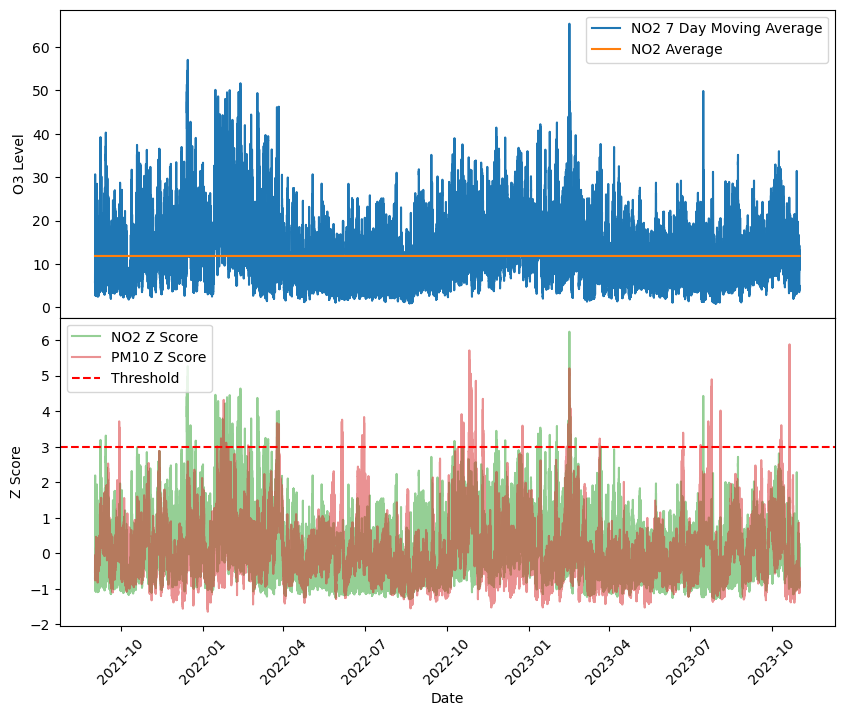

In [59]:
# Create an instance of the OutlierDetection class
outlier_detection = OutlierDetection(dataset, 'NO2', 7, 0)
dataset = outlier_detection.detect_outliers()

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Top figure
ax1.plot(dataset['Date'], dataset['NO2_7d'], label='NO2 7 Day Moving Average')
ax1.plot(dataset['Date'], dataset['NO2_0d'], label='NO2 Average')
ax1.legend()
ax1.set_ylabel('O3 Level')
# remove x-axis ticks
ax1.set_xticks([])

# Bottom figure
ax2.plot(dataset['Date'], dataset['NO2_z_score'], label='NO2 Z Score', color = 'C2', alpha = 0.5)
ax2.plot(dataset['Date'], dataset['PM10_z_score'], label='PM10 Z Score', color = 'C3', alpha = 0.5)
ax2.axhline(3, color='r', linestyle='--', label='Threshold')
ax2.legend()
ax2.set_xlabel('Date')
ax2.set_ylabel('Z Score')
ax2.tick_params(axis='x', rotation=45)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()

We definitely see some overlap here between the two parameters but not enough to say that they are clearly correlated. This data could be folded in with other reports around weather, forest fires, storms etc. to gain a clearer understanding of what is triggering these spikes. For now they give us a good understanding of how to detect spikes in time stream data. This same approach can readily be extended other forms of time stream data in order to gain a clearer understanding of anomalies.